## Машинное обучение, ВМК МГУ

## Практическое задание 2

### Общая информация
Дата выдачи: 9 октября 2019

Максимальная оценка: 10 баллов + 1 бонусный балл

Мягкий дедлайн: 23:59MSK 23 октября (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 30 октября.

### О задании

В этом задании вы:
- Познакомитесь с методом решения задачи регрессии на основе метода ближайших соседей.
- Реализуете алгоритм kNN для задачи регрессии.
- Изучите методы работы с категориальными и текстовыми переменными.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-02-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-02-ivanov.ipynb).

Далее отправьте этот файл на anytask в соответсвующий раздел.

In [1]:
import numpy as np
import pandas as pd

Все эксперименты в этой лабораторной работе предлагается проводить на данных соревнования New York City Airbnb Open Data: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data#AB_NYC_2019.csv

В данной задаче предлагается предсказать цену на съем квартиры в зависимости от её параметров.

In [2]:
data = pd.read_csv('./data/AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
data.shape

(48895, 16)

In [4]:
# число значений у признаков
for col_name in data.columns:
    print(col_name, len(data[col_name].unique()))

id 48895
name 47906
host_id 37457
host_name 11453
neighbourhood_group 5
neighbourhood 221
latitude 19048
longitude 14718
room_type 3
price 674
minimum_nights 109
number_of_reviews 394
last_review 1765
reviews_per_month 938
calculated_host_listings_count 47
availability_365 366


In [5]:
data.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Как видите, в данных есть пропуски. Не забудьте обработать их

Заполним пропуски в колонках **name** и **host_name** значением '-1', которое будет сигнализировать о пропуске в колонке.

In [6]:
data.loc[data['name'].isna(), 'name'] = '-1'
data.loc[data['host_name'].isna(), 'host_name'] = '-1'

С колонкой $last\_review$ поступим иначе:
* $last\_review$ - рассмотрим объект $x$ такой, что $x["last\_review"] = nan$ и $x["neighbourhood"] = neigh$. Тогда $x["last\_review"]$ заполняем наиболее встречаемым значением в колонке $last\_review$ среди всех объектов $x_{i}$ тренировочной выборки: $x_{i}["neighbourhood"] = neigh$

In [7]:
%%time
is_last_review_nan = data['last_review'].isna()
for neigh in data[is_last_review_nan]['neighbourhood']:
    is_neigh = data['neighbourhood'] == neigh
    if data[is_neigh].shape[0] == 1:
        data.loc[is_last_review_nan, 'last_review'] = '-1'
    else:
        data.loc[is_neigh & is_last_review_nan, 'last_review'] = data[is_neigh]['last_review'].value_counts().idxmax()

CPU times: user 1min 7s, sys: 32.8 ms, total: 1min 7s
Wall time: 1min 7s


А для колонки **$reviews\_per\_month$** возьмем не наиболее встречаемое значение, а среднее:

In [8]:
%%time
is_reviews_per_month_nan = data['reviews_per_month'].isna()
for neigh in data[is_last_review_nan]['neighbourhood']:
    is_neigh = data['neighbourhood'] == neigh
    if data[is_neigh].shape[0] == 1:
        data.loc[is_reviews_per_month_nan, 'reviews_per_month'] = -1
    else:
        data.loc[is_neigh & is_reviews_per_month_nan, 'reviews_per_month'] = data[is_neigh]['reviews_per_month'].mean()

CPU times: user 40.6 s, sys: 12 ms, total: 40.6 s
Wall time: 40.7 s


Разобъем данные на обучение и контроль.

Для тестирования модели без категориальных признаков:

In [9]:
from sklearn.model_selection import train_test_split
X_train_non_cat, X_test_non_cat, y_train_non_cat, y_test_non_cat = train_test_split(data.drop(columns=['price',
                                                                                              'last_review',
                                                                                              'name',
                                                                                              'host_name',
                                                                                              'neighbourhood_group',
                                                                                              'neighbourhood',
                                                                                              'room_type']),
                                                                                    data[['price']],
                                                                                    test_size=0.3, random_state=241)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']),
                                                    data[['price']],
                                                    test_size=0.3, random_state=241)

## Часть 1: Алгоритм kNN в задаче регрессии

<b> 1.1 (1.5 балла) </b>
Реализуйте класс `KNNRegressor`, который используя метод k ближайших соседей решает задачу регрессии. Для решение данной задачи, необходимо найти $N_k$ - k соседей, и после использовать значения их целевых переменных для предсказания:
\begin{align}
y = \frac{1}{k}\sum_{n \in N_k}w_n y_n,
\end{align}

где $w_n$ - вес каждого соседа. 

При этом `KNNRegressor` может работать в 2 режимах:
 - $uniform$ - ближайшие соседи учитываются с одинаковыми весами.
 - $distance$ - вес ближайших соседей зависит от расстояния
 
Сигнатуру методов при желании можно менять.

In [30]:
from typing import Union, Callable, Iterable, Optional
from sklearn.neighbors import NearestNeighbors


class KNNRegressor:
    def __init__(self, n_neighbors: int,
                 metric: Union[str, Callable],
                 mode: str = 'uniform',
                test_block_size = 10):
        """
        params:
            n_neighbors: number of neighbors
            metric: metric to use for distance computation
            mode: 'uniform' or 'distance'
            'uniform' - all points in each neighborhood are weighted equally
            'distance' - weight points by the inverse of their distance
            test_block_size: block size for finding neighbors and predict (for saving memory)
        """
        
        self.metric = metric
        self.__nn = None
        if self.metric != 'overlap':
            self.__nn = NearestNeighbors(n_neighbors=n_neighbors, metric=self.metric, algorithm='brute',
                                        n_jobs=1)
        self.__mode = mode
        self.n_neighbors = n_neighbors
        self.test_block_size = test_block_size
        self.X_train = None
        self.y_train = None
        self.neigh_idxs = None
        self.distances = None

    def fit(self, X: np.array, y: np.array) -> None:
        """
            X: data
            y: labels
        """
        
        self.y_train = y
        if self.__nn is None:
            self.X_train = X
        else:
            self.__nn.fit(X, y)
        self.eps = 1e-5
        
        
    def find_kneighbors(self, X, return_distance):
        """
        params:
            * X - objects sample
            * return_distance - bool variable

        return values:
            * If return_distance == True:
                * tuple with two numpy array with size (X.shape[0], k), where:
                  [i, j] elem of first array must be the distance between
                  i-th object and his j-th nearest neighbour
                  [i, j] elem of second array must be the index of j-th nearest neighbour to i-th object
            * If return_distance == False:
                * only second array
        """


        if self.__nn is not None:
            self.distances, \
                self.neigh_idxs = self.__nn.kneighbors(X, n_neighbors=self.n_neighbors)
        else:
            if self.metric == 'overlap':
                self.distances = overlap(X, self.X_train)
            if return_distance:
                self.neigh_idxs = np.argsort(self.distances,
                                         axis=1)[:, :self.n_neighbors] 
                self.distances = self.distances[np.arange(self.distances.shape[0])[:, None],
                                                self.neigh_idxs]
        if return_distance:
            return self.distances, self.neigh_idxs
        return self.neigh_idxs

    def predict(self, X: np.array, n_neighbors: Optional[int] = None) -> np.array:
        """
            X: data
            n_neighbors: number of neighbors
        """
        if n_neighbors is not None:
            n_neighbors = np.minimum(self.n_neighbors, n_neighbors)
        else:
            n_neighbors = self.n_neighbors
        if self.test_block_size > X.shape[0]:
            self.test_block_size = X.shape[0]
        preds = np.zeros(X.shape[0])
        split_size = X.shape[0] // self.test_block_size + \
                     int(X.shape[0] % self.test_block_size != 0)
        curr_idx = 0
        for i, split in enumerate(np.array_split(X, split_size)):
            self.distances, self.neigh_idxs = self.find_kneighbors(split,
                                                                   return_distance=True
                                                                  )
            for j, idx in enumerate(self.neigh_idxs):
                if self.__mode == 'distance':
                    weights = 1 / (self.distances[j] + self.eps)
                    pred = np.sum(self.y_train.values[idx].reshape(-1) * weights) / np.sum(weights)
                else:
                    pred = np.sum(self.y_train.values[idx].reshape(-1)) / n_neighbors
                preds[j + curr_idx] = pred
            curr_idx += split.shape[0]
        return preds
    
    
    def predict_without_testblock(self, X):
        """
        Similar to predict, but without memory optimization
        params:
            * X - test objects

        return values:
            * preds - numpy array of predictions for test

        """
        
        self.distances, self.neigh_idxs = self.find_kneighbors(X,
                                                               return_distance=True
                                                              )
        preds = np.zeros(X.shape[0])
        for j, idx in enumerate(self.neigh_idxs):
            if self.__mode == 'distance':
                weights = 1 / (self.distances[j] + self.eps)
                pred = np.sum(self.y_train.values[idx].reshape(-1) * weights) / np.sum(weights)
            else:
                pred = np.sum(self.y_train.values[idx].reshape(-1)) / self.n_neighbors
            preds[j] = pred
        return preds
    
    
    def predict_opt(self, X):
        """
        Optimized prediction for classification (for fast calculating score for different k)
        params:
            * X - test objects

        return values:
            * preds - numpy array of predictions for test

        """

        preds = np.zeros(X.shape[0])
        for j, idx in enumerate(self.neigh_idxs[:, :self.n_neighbors]):
            if self.__mode == 'distance':
                weights = 1 / (self.distances[j, :self.n_neighbors] + self.eps)
                counts = np.bincount(self.y_train.values[idx].reshape(-1),  weights)
            else:
                counts = np.bincount(self.y_train.values[idx].reshape(-1))
            preds[j] = np.argmax(counts)
        return preds
    
    
    def predict_opt_regression(self, X):
        """
        Optimized prediction for regression (for fast calculating score for different k)
        params:
            * X - test objects

        return values:
            * preds - numpy array of predictions for test

        """

        preds = np.zeros(X.shape[0])
        for j, idx in enumerate(self.neigh_idxs[:, :self.n_neighbors]):
            if self.__mode == 'distance':
                weights = 1 / (self.distances[j, :self.n_neighbors] + self.eps)
                pred = np.sum(self.y_train[idx] * weights) / np.sum(weights)
            else:
                pred = np.sum(self.y_train[idx]) / self.n_neighbors
            preds[j] = pred
        return preds

Напишем функцию rmse для подсчета метрики RMSE

In [32]:
def rmse(y_true, y_valid):
    return (np.sum((y_valid - y_true) ** 2) / len(y_true)) ** (1/2)

## Часть 2: Категориальные признаки

<b>2.1 (1 балл)</b>
Реализуйте три функции расстояния на категориальных признаках, которые обсуждались на [третьем семинаре](https://github.com/mmp-mmro-team/mmp_mmro_fall_2019/blob/master/lecture-notes/Sem03_knn.pdf). Не забудьте, что KNNRegressor должен уметь работать с этими функциями расстояния. Как вариант, можно реализовать метрики как [user-defined distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html).

In [16]:
# import pyximport; pyximport.install() Попытки переписать метрики на Cython оказались безуспешными
# import overlap_cython

In [17]:
data_cat = data.copy()

Оставим 3 категориальных признака: 'neighbourhood_group', 'neighbourhood', 'room_type'.

In [19]:
data_cat.drop(['id', 'name', 'host_id', 'host_name', 'latitude', 'longitude',
              'minimum_nights', 'number_of_reviews', 'last_review', 
               'reviews_per_month', 'calculated_host_listings_count', 'availability_365'], axis=1, inplace=True)

Посчитаем статистику для всех данных для ускорения работы метрик

In [20]:
from tqdm import tqdm_notebook

In [99]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for column in data_cat.columns[:-1]:
    all_classes_in_col = data_cat[column].unique()
    le.fit(all_classes_in_col)
    data_cat.loc[:, column] = le.transform(data_cat.loc[:, column]) + 1

In [102]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(data_cat.drop(columns=['price']),
                                                                    data_cat[['price']],
                                                                    test_size=0.3)

Произведем предпосчет статистики для ускорения работы метрик:

In [103]:
%%time
p2_sum_stat_dict = {}
data_cat_np = data_cat.drop('price', axis=1).to_numpy(copy=True)
X_train_cat_np = X_train_cat.to_numpy(copy=True)
f_stat = np.zeros((data_cat.shape[0], X_train_cat_np.shape[1]))


for i, columns in enumerate(zip(data_cat_np.T, X_train_cat_np.T)):
    column_data, column_train = columns
    print(column_train)
    print(column_data)
    is_equal = column_data[:, None] == column_train
    f_stat[:, i] = np.sum(is_equal, axis=1)

[2 3 4 ... 2 2 2]
[2 3 3 ... 3 3 3]
[109  87 190 ...  14 191  52]
[109 128  95 ...  95  96  96]
[2 1 2 ... 1 1 2]
[2 1 2 ... 1 3 2]
CPU times: user 3.3 s, sys: 353 ms, total: 3.65 s
Wall time: 3.65 s


In [105]:
f_stat_log_dict = {}
for i, elem in enumerate(tqdm_notebook(data_cat_np)):
    f_stat_log_dict[tuple(elem)] = np.log(f_stat[i, :] + 1)

In [109]:
p2_sum_arr = np.zeros(X_train_cat.shape[1])
p2_sum_stat = np.zeros((data_cat.shape[0], X_train_cat.shape[1]))
for i, line in enumerate(tqdm_notebook(data_cat_np)):
    for j, x_val in enumerate(line):
        f_x = X_train_cat.iloc[:, j].value_counts()
        p2 = f_x
        p2 = p2 * (p2 - 1) / (X_train_cat.shape[0] * (X_train_cat.shape[0] - 1))
        if x_val in f_x:
            p2_sum_arr[j] = np.sum(p2 * (f_x.values <= f_x[x_val]))
        else:
            p2_sum_arr[j] = np.sum(p2 * (f_x.values <= 0))
    p2_sum_stat[i, :] = p2_sum_arr

In [110]:
p2_sum_stat_dict = {}
for i, elem in enumerate(tqdm_notebook(data_cat_np)):
    p2_sum_stat_dict[tuple(elem)] = p2_sum_stat[i, :]

In [29]:
df_x = data_cat.copy()
df_z = data_cat.copy()
df = data_cat.copy()

In [62]:
def overlap(x, z):
    """
    params:
        * x - DataFrame with size n * l
        * z - DataFrame with size m * l
    return values:
        n * m matrix with pairwise distances
    """
    x = x.to_numpy(copy=True)
    z = z.to_numpy(copy=True)
    is_equal = x[:, None] != z
    return np.sum(is_equal, axis=2)

def flattened_overlap(x, z):
    """
    params:
        * x - numpy array of size d
        * z - numpy array of size d
    return values:
        flattened overlap distance between x and z
    """
    result = np.sum(x != z) + np.sum((x == z) * p2_sum_stat_dict[tuple(x)])
    return result


def log_overlap(x, z):
    """
    params:
        * x - numpy array of size d
        * z - numpy array of size d
    return values:
        log overlap distance between x and z
    """
    result = np.sum((x != z) * f_stat_log_dict[tuple(x)] * f_stat_log_dict[tuple(z)])
    return result

<b>2.2 (1 балл)</b> Найдите все категориальные признаки в данных. Подсчитайте для каждой из метрик качество на тестовой выборке `X_test` при числе соседей $k = 10$. Качество измеряйте с помощью RMSE.

Какая функция расстояния оказалась лучшей? Почему?

Подсчитаем расстояния и индексы соседей заранее, чтобы быстрее делать предсказания для различных k:

In [32]:
knn_with_distances = KNNRegressor(200, metric='overlap', mode='uniform', test_block_size=1000)
knn_with_distances.fit(X_train_cat, y_train_cat.values)

In [33]:
%%time
overlap_distances, overlap_indx = knn_with_distances.find_kneighbors(X_test_cat,
                                                                     return_distance=True)

CPU times: user 8.03 s, sys: 652 ms, total: 8.69 s
Wall time: 8.69 s


In [34]:
knn_with_distances = KNNRegressor(200, metric=flattened_overlap, mode='uniform', test_block_size=1000)
knn_with_distances.fit(X_train_cat, y_train_cat.values)

In [35]:
%%time
flattened_overlap_distances, flattened_overlap_indx = knn_with_distances.find_kneighbors(X_test_cat,
                                                                                         return_distance=True)

CPU times: user 2h 49min 5s, sys: 4min 25s, total: 2h 53min 31s
Wall time: 2h 38min 42s


In [36]:
knn_with_distances = KNNRegressor(200, metric=log_overlap, mode='uniform', test_block_size=1000)
knn_with_distances.fit(X_train_cat, y_train_cat.values)

In [37]:
%%time
log_overlap_distances, log_overlap_indx = knn_with_distances.find_kneighbors(X_test_cat,
                                                                             return_distance=True)

CPU times: user 2h 48min 7s, sys: 4min 10s, total: 2h 52min 18s
Wall time: 2h 38min 12s


#### Достаточно просто изменять два аттрибута KNNRegressor: $distances$ и $neigh\_idxs$, так как методу $predict\_opt\_regression$ нужны только они для предсказания.

In [496]:
knn_with_distances.distances = overlap_distances[:, :]
knn_with_distances.neigh_idxs = overlap_indx[:, :]
best_params = {'rmse': 1000, 'k': 0}
for k in [10]:
    knn_with_distances.n_neighbors = k
    preds = knn_with_distances.predict_opt_regression(X_test)
    rmse_curr = rmse(y_test_cat.values.reshape(-1), preds)
    print(f"Количество соседей: {k}, RMSE: {rmse_curr}")
    if rmse_curr < best_params['rmse']:
        best_params['rmse'] = rmse_curr
        best_params['k'] = k

Количество соседей: 10, RMSE: 227.4506863689404


In [497]:
knn_with_distances.distances = flattened_overlap_distances[:, :]
knn_with_distances.neigh_idxs = flattened_overlap_indx[:, :]
best_params = {'rmse': 1000, 'k': 0}
for k in [10]:
    knn_with_distances.n_neighbors = k
    preds = knn_with_distances.predict_opt_regression(X_test)
    rmse_curr = rmse(y_test_cat.values.reshape(-1), preds)
    print(f"Количество соседей: {k}, RMSE: {rmse_curr}")
    if rmse_curr < best_params['rmse']:
        best_params['rmse'] = rmse_curr
        best_params['k'] = k

Количество соседей: 10, RMSE: 209.48714805630325


In [498]:
knn_with_distances.distances = log_overlap_distances[:, :]
knn_with_distances.neigh_idxs = log_overlap_indx[:, :]
best_params = {'rmse': 1000, 'k': 0}
for k in [10]:
    knn_with_distances.n_neighbors = k
    preds = knn_with_distances.predict_opt_regression(X_test)
    rmse_curr = rmse(y_test_cat.values.reshape(-1), preds)
    print(f"Количество соседей: {k}, RMSE: {rmse_curr}")
    if rmse_curr < best_params['rmse']:
        best_params['rmse'] = rmse_curr
        best_params['k'] = k

Количество соседей: 10, RMSE: 239.034076340855


Как видим из результатов эксперимента - наилучшее качество на 10 соседях показал алгоритм с метрикой расстояния "**сглаженный индикатор совпадения**" (**flattened_overlap**). Так как он учитывает частоту значения признака: чем выше частота, тем больше расстояние (если оба объекта имеют значение признака, которое часто встречается, то эта информация не так важна, так как вероятность такого совпадения высока).

<b>2.3 (1 балл) бонус</b> Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какого удалось достичь уровня качества?

Аналогично предыдущему пункту будем изменять аттрибуты $distances$ и $neigh\_idxs$. Дополнительно изменяем в цикле $n\_neighbors$, с помощью которого выбор нужного числа соседей из $distances$ и $neigh\_idxs$

In [118]:
knn_with_distances.distances = overlap_distances[:, :]
knn_with_distances.neigh_idxs = overlap_indx[:, :]
best_params = {'rmse': 1000, 'k': 0}
for k in range(1, 200):
    knn_with_distances.n_neighbors = k
    preds = knn_with_distances.predict_opt_regression(X_test)
    rmse_curr = rmse(y_test_cat.values.reshape(-1), preds)
    if rmse_curr < best_params['rmse']:
        best_params['rmse'] = rmse_curr
        best_params['k'] = k
best_params

{'rmse': 207.3201331722447, 'k': 192}

In [120]:
knn_with_distances.distances = flattened_overlap_distances[:, :]
knn_with_distances.neigh_idxs = flattened_overlap_indx[:, :]
best_params = {'rmse': 1000, 'k': 0}
for k in range(1, 200):
    knn_with_distances.n_neighbors = k
    preds = knn_with_distances.predict_opt_regression(X_test)
    rmse_curr = rmse(y_test_cat.values.reshape(-1), preds)
    if rmse_curr < best_params['rmse']:
        best_params['rmse'] = rmse_curr
        best_params['k'] = k
best_params

{'rmse': 207.49810130642814, 'k': 125}

In [121]:
knn_with_distances.distances = log_overlap_distances[:, :]
knn_with_distances.neigh_idxs = log_overlap_indx[:, :]
best_params = {'rmse': 1000, 'k': 0}
for k in range(1, 200):
    knn_with_distances.n_neighbors = k
    preds = knn_with_distances.predict_opt_regression(X_test)
    rmse_curr = rmse(y_test_cat.values.reshape(-1), preds)
    if rmse_curr < best_params['rmse']:
        best_params['rmse'] = rmse_curr
        best_params['k'] = k
best_params

{'rmse': 207.1962663210132, 'k': 193}

Для **overlap** оптимальное количество соседей получилось $= 192$

Для **flattened overlap** $= 125$

Для **log overlap** $= 193$

Удалось достичь наилучшего значения $RMSE = \textbf{207.2}$ (при использовании **log overlap**)

<b>2.4 (2.5 балла)</b> Отойдем ненадолго от задачи регрессии и перейдём к задаче классификации: будем определять, являеться ли квартира дорогой $(target = 1)$ или дешевой $(target = 0)$. Будем считать дорогими квариры, цена которых выше среднего.

In [769]:
data_cat['target'] = (data_cat.price > data_cat.price.mean()).astype(int) ## чтобы снова удалять признаки из data

In [55]:
data['target'] = (data.price > data.price.mean()).astype(int)

Реализуйте счетчики, которые заменят категориальные признаки на вещественные.

А именно, для каждого категориального признака $f_j(x)$ необходимо сделать следующее:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
\begin{align}
counts_j(c) = \sum_{i=1}^l [f_j(x_i) = c]
\end{align}
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
\begin{align}
successes_j(c) = \sum_{i=1}^l[f_j(x_i) = c][y_i = +1].
\end{align}
3. Сглаженное отношение двух предыдущих величин:
\begin{align}
p_j(c) = \frac{successes_j(c) + a}{counts_j(c) + b},
\end{align}

где $a$ и $b$ - априорные счетчики (например, a = 1, b = 2).

In [63]:
def counts(x, x_tr):
    """
    params:
        x - pandas series (one categorical feature), which we want to fill with counter
        x_tr - pandas series (one categorical feautre), BY which we want to fill x
    return values:
        numpy array with counts
    """
    
    x = x.to_numpy()
    x_tr = x_tr.to_numpy()
    return np.sum(x[:, None] == x_tr, axis=1)


def successes(x, x_tr, y):
    """
    params:
        x - pandas series (one categorical feature), which we want to fill with successes
        x_tr - pandas series (one categorical feautre), BY which we want to fill x
    return values:
        numpy array with successes
    """
    
    x = x.to_numpy()
    x_tr = x_tr.to_numpy()
    y = y.to_numpy()
    result = np.sum((x[:, None] == x_tr) * (y == 1), axis=1)
    return result
    

def flattened_c_s(x, x_tr, y, a=1, b=2):
    """
    params:
        x - pandas series (one categorical feature), which we want to fill with successes
        x_tr - pandas series (one categorical feautre), BY which we want to fill x
    return values:
        numpy array with flattened successes and counts
    """
    
    return (successes(x, x_tr, y) + a) / (counts(x, x_tr) + b)

Напишем функцию, которая заполняет данный DataFrame по значениям X_train с целевой перменной y (от X_train)

In [64]:
def counters(df_cat, X_train, y):
    df_copy = df_cat.copy()
    for column in df_copy.columns:
        df_copy[column + '_counts'] = counts(df_copy[column], X_train[column])
        df_copy[column + '_successes'] = successes(df_copy[column], X_train[column], y)
        df_copy[column + '_flattened_c_s'] = flattened_c_s(df_copy[column], X_train[column], y)
        df_copy.drop(column, axis=1, inplace=True)
    return df_copy

In [847]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(data_cat.drop(columns=['price', 'target']),
                                                                                  data_cat[['target']],
                                                                                  test_size=0.3, random_state=241)

Закодируем с помощью $LabelEncoder$ категориальные признаки, добавив 1 к каждому столбцу признаков, так как $LabelEncoder$ кодирует с 0, то при подсчете статистик могли бы возникнуть проблемы.

In [848]:
le = LabelEncoder()
for column in X_train_cat.columns:
    all_classes_in_col = np.hstack([X_train_cat[column].unique(), X_test_cat[column].unique()])
    le.fit(all_classes_in_col)
    X_train_cat.loc[:, column] = le.transform(X_train_cat.loc[:, column]) + 1
    X_test_cat.loc[:, column] = le.transform(X_test_cat.loc[:, column]) + 1

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанный по всей обучающей выборке. Реализуйте и такой вариант. Достаточно взять $n = 3$.

## Реализуем kfold:

In [65]:
def kfold(indices, n_folds=3):
    """
    params:
        * indices - np.array of indices
        * n_folds - folds amount
    return values:
        * list with size n_folds, where every element is tuple of two 1D numpy array:
            * first array contains indices of train samples
            * second array contains indices of validation samples
    """

#     np.random.shuffle(indices)
    n = len(indices)
    size_of_one_fold = int(n / n_folds) + (n < n_folds)
    size_with_folds = size_of_one_fold * n_folds
    out_elements_amount = len(indices) - size_with_folds
    train_test_idx_list = []
    for i in range(n_folds):
        test_idx = indices[i * size_of_one_fold:(i + 1) * size_of_one_fold]
        if out_elements_amount > 0:
            test_idx = np.append(test_idx, n - out_elements_amount)
            out_elements_amount -= 1
        train_idx = np.array(list((set(indices) - set(test_idx))))
        train_test_idx_list.append((train_idx, test_idx))
    return train_test_idx_list

Реализуем подсчет статистик по фолдам:

In [66]:
def counts_with_folds(x, n_folds=3):
    """
    x - one categorical column with type - pandas series
    n_folds - amount of folds
    """
    
    result = x.copy()
    result.iloc[:] = 0
    for help_indx, main_indx in kfold(x.index, n_folds):
        unique_elems = np.unique(x[help_indx])
        counts_per_fold = {x : 0 for x in unique_elems}
        for unique_elem in unique_elems:
            counts_per_fold[unique_elem] = np.sum((x[help_indx] == unique_elem))
            result[np.array((x[main_indx] == unique_elem)[x[main_indx] == unique_elem].index)] = counts_per_fold[unique_elem]
    return result

In [67]:
def successes_with_folds(x, y, n_folds=3):
    """
    x - one categorical column with type - pandas series
    y - target feature from df
    n_folds - amount of folds
    """
    
    result = x.copy()
    result.iloc[:] = 0
    for help_indx, main_indx in kfold(x.index, n_folds):
        unique_elems = np.unique(x[help_indx])
        successes_per_fold = {x : 0 for x in unique_elems}
        for unique_elem in unique_elems:
            successes_per_fold[unique_elem] = np.sum((x[help_indx] == unique_elem) & (y[help_indx] == 1))
            result[np.array((x[main_indx] == unique_elem)[x[main_indx] == unique_elem].index).reshape(-1)] = successes_per_fold[unique_elem]
    return result

In [68]:
def flattened_c_s_with_folds(x, y, n_folds=3, a=1, b=2):
    """
    x - one categorical column with type - pandas series
    y - target feature from df
    n_folds - amount of folds
    """
    
    result = x.copy()
    result.iloc[:] = 0
    counts = result.copy()
    successes = result.copy()
    for help_indx, main_indx in kfold(x.index, n_folds):
        unique_elems = np.unique(x[help_indx])
        successes_per_fold = {x : 0 for x in unique_elems}
        counts_per_fold = {x : 0 for x in unique_elems}
        for unique_elem in unique_elems:
            counts_per_fold[unique_elem] = np.sum((x[help_indx] == unique_elem))
            counts[np.array((x[main_indx] == unique_elem)[x[main_indx] == unique_elem].index)] = counts_per_fold[unique_elem]
            successes_per_fold[unique_elem] = np.sum((x[help_indx] == unique_elem) & (y[help_indx] == 1))
            successes[np.array((x[main_indx] == unique_elem)[x[main_indx] == unique_elem].index)] = successes_per_fold[unique_elem]
    result = (successes + a) / (counts + b)
    return result

Заполнение DataFrame статистиками по фолдам

In [69]:
def counters_with_folds(df_cat, y):
    df_copy = df_cat.copy()
    for column in df_copy.columns:
        df_copy[column + '_counts'] = counts_with_folds(df_copy.loc[:, column])
        df_copy[column + '_successes'] = successes_with_folds(df_copy.loc[:, column], y)
        df_copy[column + '_flattened_c_s'] = flattened_c_s_with_folds(df_copy.loc[:, column], y)
        df_copy.drop(column, axis=1, inplace=True)
    return df_copy

Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

## Без фолдинга

In [866]:
from sklearn.metrics import roc_auc_score

In [867]:
X_train_cat_without_folding = counters(X_train_cat, X_train_cat, y_train_cat['target'])

In [868]:
X_test_cat_without_folding = counters(X_test_cat, X_train_cat, y_train_cat['target'])

In [869]:
logs = np.zeros((1, 4))

In [870]:
weights_list = ['uniform']
k_max = 15
k_list = np.arange(k_max)
best_score_param = {'score': None, 'param': None}
for weights in weights_list:
    knn_regressor = KNNRegressor(k_max, metric='euclidean', mode=weights, test_block_size=10000)
    knn_regressor.fit(X_train_cat_without_folding, y_train_cat['target'])
    knn_regressor.find_kneighbors(X_test_cat_without_folding, return_distance=True)
    for k in k_list[1:]:
        knn_regressor.n_neighbors = k
        pred = knn_regressor.predict_opt(X_test_cat_without_folding)
        roc_auc = roc_auc_score(pred.reshape(-1), y_test_cat['target'].values.reshape(-1))
        print(f'n_neighbors: {k}, weights: {weights}, roc_auc: {roc_auc}')
        if best_score_param['score'] is None:
            best_score_param['score'] = roc_auc
            best_score_param['param'] = str(weights) + '_' + str(k)            
        elif abs(best_score_param['score'] - 0.5) < abs(roc_auc - 0.5):
            best_score_param['score'] = roc_auc
            best_score_param['param'] = str(weights) + '_' + str(k) 
        logs = np.append(logs, 
                             np.array(['Без фолдинга',
                                        k,
                                        weights,
                                        roc_auc])[None, :],
                                        axis=0)

n_neighbors: 1, weights: uniform, roc_auc: 0.7118803376103604
n_neighbors: 2, weights: uniform, roc_auc: 0.7310142496654174
n_neighbors: 3, weights: uniform, roc_auc: 0.7292143529965854
n_neighbors: 4, weights: uniform, roc_auc: 0.7384337762122508
n_neighbors: 5, weights: uniform, roc_auc: 0.7619850417267447
n_neighbors: 6, weights: uniform, roc_auc: 0.7647751806341901
n_neighbors: 7, weights: uniform, roc_auc: 0.7593130472459989
n_neighbors: 8, weights: uniform, roc_auc: 0.76366596882462
n_neighbors: 9, weights: uniform, roc_auc: 0.7624760903306405
n_neighbors: 10, weights: uniform, roc_auc: 0.7607568183714146
n_neighbors: 11, weights: uniform, roc_auc: 0.762628178272686
n_neighbors: 12, weights: uniform, roc_auc: 0.7600281879085735
n_neighbors: 13, weights: uniform, roc_auc: 0.7657084147395725
n_neighbors: 14, weights: uniform, roc_auc: 0.767865040151628


In [871]:
best_score_param

{'score': 0.767865040151628, 'param': 'uniform_14'}

## С фолдингом

In [872]:
X_train_cat_with_folding = counters_with_folds(X_train_cat, y_train_cat['target'])

In [874]:
weights_list = ['uniform']
k_max = 15
k_list = np.arange(k_max)
best_score_param = {'score': None, 'param': None}
for weights in weights_list:
    knn_regressor = KNNRegressor(k_max, metric='euclidean', mode=weights, test_block_size=10000)
    knn_regressor.fit(X_train_cat_with_folding, y_train_cat['target'])
    knn_regressor.find_kneighbors(X_test_cat_without_folding, return_distance=True)
    for k in k_list[1:]:
        knn_regressor.n_neighbors = k
        pred = knn_regressor.predict_opt(X_test_cat_without_folding)
        roc_auc = roc_auc_score(pred, y_test_cat['target'].values)
        if best_score_param['score'] is None:
            best_score_param['score'] = roc_auc
            best_score_param['param'] = str(weights) + '_' + str(k)            
        elif abs(best_score_param['score'] - 0.5) < abs(roc_auc - 0.5):
            best_score_param['score'] = roc_auc
            best_score_param['param'] = str(weights) + '_' + str(k)
        logs = np.append(logs, 
                             np.array(['С фолдингом',
                                        k,
                                        weights,
                                        roc_auc])[None, :],
                                        axis=0)

In [875]:
best_score_param

{'score': 0.7527181701840073, 'param': 'uniform_5'}

In [876]:
logs_data = pd.DataFrame(logs, columns=['Тип заполнения',
                                        'Количество соседей',
                                        'Веса',
                                        'ROC_AUC'])

In [877]:
logs_data = logs_data.drop([0], axis=0) # так как первая строка - нули
logs_data.head(5)

,Тип заполнения,Количество соседей,Веса,ROC_AUC
1,Без фолдинга,1,uniform,0.7118803376103604
2,Без фолдинга,2,uniform,0.7310142496654174
3,Без фолдинга,3,uniform,0.7292143529965854
4,Без фолдинга,4,uniform,0.7384337762122508
5,Без фолдинга,5,uniform,0.7619850417267447


In [878]:
logs_data['ROC_AUC'] = logs_data['ROC_AUC'].astype(float)
logs_data['Количество соседей'] = logs_data['Количество соседей'].astype(int)

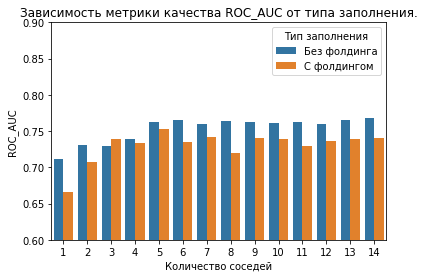

In [879]:
sns.barplot(x='Количество соседей',
            y='ROC_AUC',
            hue='Тип заполнения',
            data=logs_data)
plt.ylim(0.6, 0.9)
plt.title('Зависимость метрики качества ROC_AUC от типа заполнения.')
plt.show()

Как видно из графика - заполнение признаков без фолдинга дает результат хуже, чем с фолдингом. Это можно объяснить только тем, что в признаке 'neighbourhood_group' у тренировочной выборки есть значения, которых нет в тестовой выборке. При заполнении без фолдов в тесте оказывается не так много "неизвестных" значений, а при использовании фолдов их количество увеличивается. Возможно, поможет увеличение количества фолдов (тогда "неизвестных" значений намного меньше). 

<b>2.5 (1 балл)</b> Вернемся к задаче регрессии. Утверждается, что для задачи регрессии можно также сделать преобразование категориальных признаков в действительные числа. Для этого достаточно для каждого значения признака $f_j$ вычислить:
\begin{align}
p_j(c) = g(T_i | f_j(x_i) = c),
\end{align}

где $T_i$ - значения целевой переменной объекта $x_i$. Функция $g$ - среднее (mean) или среднеквадратичное отклонение (std).

Закодируйте категориальные признаки обоими способами и найдите значение RMSE. Используйте евклидову метрику для поиска ближайших соседей. Для какой функции $g$ значение RMSE лучше? Почему?

In [70]:
def calculate_p_j(x, y, g_func=np.mean):
    x = x.values.reshape(-1)
    y = y.values.reshape(-1)
    return g_func((x[:, None] == x) * y, axis=1)

In [71]:
def calculate_p_j_for_test(x, x_tr, y, g_func=np.mean):
    x = x.values.reshape(-1)
    y = y.values
    x_tr = x_tr.values.reshape(-1)
    return g_func((x[:, None] == x_tr) * y, axis=1)  

In [72]:
def calculate_p_j_for_df(df_train_cat, df_test_cat, y, g_func=np.mean):
    df_train_copy = df_train_cat.copy()
    df_test_copy = df_test_cat.copy()
    for column in df_train_copy.columns:
        df_train_copy[column + '_p_j'] = calculate_p_j(df_train_copy[column], y, g_func=g_func)
        df_test_copy[column + '_p_j'] = calculate_p_j_for_test(df_test_copy[column],
                                                               df_train_copy[column],
                                                               y,
                                                               g_func=g_func
                                                              )
        df_train_copy.drop(column, axis=1, inplace=True)
        df_test_copy.drop(column, axis=1, inplace=True)
    return df_train_copy, df_test_copy

In [902]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(data_cat.drop(columns=['price', 'target']),
                                                                                  data_cat[['price']],
                                                                                  test_size=0.3, random_state=241)

### Посчитаем все $p_j$ с функцией $mean$ для тренировочной и тестовой выборок:

In [903]:
X_train_cat_p_j, X_test_cat_p_j = calculate_p_j_for_df(X_train_cat, X_test_cat, y_train_cat['price'], np.mean)

Заведем массив для логирования результатов

In [904]:
logs = np.zeros((1, 4))

In [905]:
knn_regressor = KNNRegressor(15, metric='euclidean')
weights_list = ['uniform']
k_max = 15
k_list = np.arange(k_max)
best_score_param = {'score': None, 'param': None}
for weights in weights_list:
    knn_regressor = KNNRegressor(k_max, metric='euclidean', mode=weights, test_block_size=10000)
    knn_regressor.fit(X_train_cat_p_j, y_train_cat)
    knn_regressor.find_kneighbors(X_test_cat_p_j, return_distance=True)
    for k in k_list[1:]:
        knn_regressor.n_neighbors = k
        pred = knn_regressor.predict(X_test_cat_p_j)
        rmse_curr = rmse(pred, y_test_cat.values.reshape(-1))
        print(f'n_neighbors: {k}, weights: {weights}, rmse: {rmse_curr}')
        if best_score_param['score'] is None:
            best_score_param['score'] = rmse_curr
            best_score_param['param'] = str(weights) + '_' + str(k)            
        elif best_score_param['score'] > rmse_curr:
            best_score_param['score'] = rmse_curr
            best_score_param['param'] = str(weights) + '_' + str(k)
        logs = np.append(logs, 
                             np.array(['mean',
                                        k,
                                        weights,
                                        rmse_curr])[None, :],
                                        axis=0)

n_neighbors: 1, weights: uniform, rmse: 256.9955092974038
n_neighbors: 2, weights: uniform, rmse: 225.42715336866934
n_neighbors: 3, weights: uniform, rmse: 218.1166870140802
n_neighbors: 4, weights: uniform, rmse: 219.5907395782312
n_neighbors: 5, weights: uniform, rmse: 217.1871295290689
n_neighbors: 6, weights: uniform, rmse: 215.14252405305274
n_neighbors: 7, weights: uniform, rmse: 223.20601888804407
n_neighbors: 8, weights: uniform, rmse: 219.07736915691726
n_neighbors: 9, weights: uniform, rmse: 215.8916293021102
n_neighbors: 10, weights: uniform, rmse: 214.05440744727446
n_neighbors: 11, weights: uniform, rmse: 213.163973702008
n_neighbors: 12, weights: uniform, rmse: 213.1387156891674
n_neighbors: 13, weights: uniform, rmse: 212.006511881363
n_neighbors: 14, weights: uniform, rmse: 211.0541005183805


In [906]:
best_score_param

{'score': 211.0541005183805, 'param': 'uniform_14'}

 лучший результат достигается при $k=14$

### Посчитаем все $p_j$ с функцией $std$ для тренировочной и тестовой выборок:

In [907]:
X_train_cat_p_j, X_test_cat_p_j = calculate_p_j_for_df(X_train_cat, X_test_cat, y_train_cat['price'],
                                                       np.std)

In [908]:
knn_regressor = KNNRegressor(15, metric='euclidean')
weights_list = ['uniform']
k_max = 15
k_list = np.arange(k_max)
best_score_param = {'score': None, 'param': None}
for weights in weights_list:
    knn_regressor = KNNRegressor(k_max, metric='euclidean', mode=weights, test_block_size=10000)
    knn_regressor.fit(X_train_cat_p_j, y_train_cat)
    knn_regressor.find_kneighbors(X_test_cat_p_j, return_distance=True)
    for k in k_list[1:]:
        knn_regressor.n_neighbors = k
        pred = knn_regressor.predict(X_test_cat_p_j)
        rmse_curr = rmse(pred, y_test_cat.values.reshape(-1))
        print(f'n_neighbors: {k}, weights: {weights}, rmse: {rmse_curr}')
        if best_score_param['score'] is None:
            best_score_param['score'] = rmse_curr
            best_score_param['param'] = str(weights) + '_' + str(k)            
        elif best_score_param['score'] > rmse_curr:
            best_score_param['score'] = rmse_curr
            best_score_param['param'] = str(weights) + '_' + str(k)
        logs = np.append(logs, 
                         np.array(['std',
                                    k,
                                    weights,
                                    rmse_curr])[None, :],
                                    axis=0)

n_neighbors: 1, weights: uniform, rmse: 257.06013753417153
n_neighbors: 2, weights: uniform, rmse: 225.45899483263952
n_neighbors: 3, weights: uniform, rmse: 218.1486452763526
n_neighbors: 4, weights: uniform, rmse: 242.98248169914015
n_neighbors: 5, weights: uniform, rmse: 231.78584953277328
n_neighbors: 6, weights: uniform, rmse: 224.5639471709267
n_neighbors: 7, weights: uniform, rmse: 223.55743097103192
n_neighbors: 8, weights: uniform, rmse: 219.23957591637205
n_neighbors: 9, weights: uniform, rmse: 223.016634459386
n_neighbors: 10, weights: uniform, rmse: 219.19152581574295
n_neighbors: 11, weights: uniform, rmse: 216.856813040564
n_neighbors: 12, weights: uniform, rmse: 215.19329847854564
n_neighbors: 13, weights: uniform, rmse: 213.61807902111028
n_neighbors: 14, weights: uniform, rmse: 212.82925240340748


In [909]:
best_score_param

{'score': 212.82925240340748, 'param': 'uniform_14'}

Лучший результат при $k=14$

### Построим график зависимости метрики качества RMSE от типа заполнения

In [910]:
logs_data = pd.DataFrame(logs, columns=['Функция',
                                        'Количество соседей',
                                        'Веса',
                                        'RMSE'])

In [911]:
logs_data = logs_data.drop([0], axis=0) # так как первая строка - нули
logs_data.head(5)

,Функция,Количество соседей,Веса,RMSE
1,mean,1,uniform,256.9955092974038
2,mean,2,uniform,225.42715336866934
3,mean,3,uniform,218.1166870140802
4,mean,4,uniform,219.5907395782312
5,mean,5,uniform,217.1871295290689


In [912]:
logs_data['RMSE'] = logs_data['RMSE'].astype(float)
logs_data['Количество соседей'] = logs_data['Количество соседей'].astype(int)

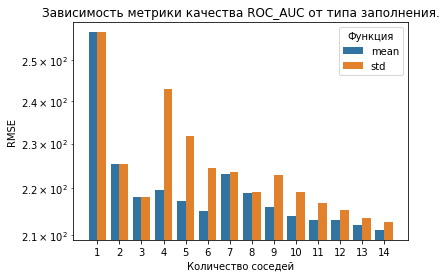

In [913]:
sns.barplot(x='Количество соседей',
            y='RMSE',
            hue='Функция',
            data=logs_data)
plt.semilogy()
plt.title('Зависимость метрики качества ROC_AUC от типа заполнения.') ## Опечатка: не ROC_AUC, а RMSE.
                                                                    ## Не было возможности перезапустить ноутбук :(
plt.show()

Как видно из результатов функция $g = mean$ дает качество лучше, чем std. Предполагаю, что это связано с тем, что функция $std$ очень чувствительна к уникальным признакам. Допустим, что в признаке $p_j$ есть значение $c$, которое принимает всего один объект, тогда при преобразовании 
$p_j(c) = std(T_i | f_j(x_i) = c)$ значение признака изменится на 0, что является не очень информативным.

## Часть 3: Текстовые признаки

<b>3.1 (2 балла)</b> Перейдем от категориальным признаков к текстовым. Рассмотрим 2 способа преобразования текста в действительные числа:
- Мешок слов (Bag of Words)
- TF-IDF

[Здесь](https://scikit-learn.org/stable/modules/feature_extraction.html) вы можете прочитать про их применение в Питоне.

Сравните оба способа на задаче регресси. Какую лучше метрику использовать: евклидову или косинусную меру? Постройте графики зависимости качества решения задачи от способа преобразования, метрики и количества соседей. Мера качества - RMSE.

Объясните полученные результаты.

Перед преобразованием не забудьте уменьшить размер словаря. Например, это можно сделать за счет приведения всех слов к одному регистру и удаления [стопслов](https://en.wikipedia.org/wiki/Stop_words) (артиклей, предлогов, союзов).

## Загрузим множество стоп-слов

In [9]:
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/paniquex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Удалим пунктуацию и приведем все к одному регистру

In [10]:
data_text = data.copy()
data_text['name'] = data_text['name'] + data_text['host_name']
data_text['name'] = data_text['name'].str.lower()
data_text['name'] = data_text['name'].str.split()
data_text['name'] = data_text['name'].apply(lambda x: [elem for elem in x if elem not in stopwords_set])

In [22]:
data_text['name'] = data_text['name'].apply(lambda x: ' '.join(x))

## Bag of Words

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
vectorizer = CountVectorizer(lowercase=False)

In [25]:
data_with_text_features_bag = vectorizer.fit_transform(data_text['name'])

In [27]:
from sklearn.model_selection import train_test_split
X_train_with_text, X_test_with_text, y_train_with_text, y_test_with_text = train_test_split(data_with_text_features_bag,
                                                                                    data[['price']].values,
                                                                                    test_size=0.3, random_state=241)

In [33]:
logs = np.zeros((1, 5))

In [34]:
metrics_list = ['euclidean', 'cosine']
weights_list = ['uniform', 'distance']
k_max = 21
k_list = np.arange(2, k_max)
best_score_param = {'score': None, 'param': None}
for metrics in metrics_list:
    for weights in weights_list:
        knn_regressor = KNNRegressor(k_max, metric=metrics, mode=weights, test_block_size=10000)
        knn_regressor.fit(X_train_with_text, y_train_with_text.reshape(-1))
        knn_regressor.find_kneighbors(X_test_with_text, return_distance=True)
        for k in k_list[1:]:
            knn_regressor.n_neighbors = k
            pred = knn_regressor.predict_opt_regression(X_test_with_text)
            rmse_score = rmse(pred, y_test_with_text.reshape(-1))
            if best_score_param['score'] is None:
                best_score_param['score'] = rmse_score
                best_score_param['param'] = str(weights) + '_' + str(k) + '_' + str(metrics)           
            elif best_score_param['score'] > rmse_score:
                best_score_param['score'] = rmse_score
                best_score_param['param'] = str(weights) + '_' + str(k) + '_' + str(metrics)
            logs = np.append(logs, 
                             np.array(['BOW',
                                        k,
                                        weights,
                                        metrics,
                                        rmse_score])[None, :],
                                        axis=0)

In [35]:
best_score_param

{'score': 205.92741917266707, 'param': 'distance_19_cosine'}

## TF-IDF

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
vectorizer_tfid = TfidfVectorizer()
data_with_text_features_tfidf = vectorizer_tfid.fit_transform(data_text['name'])

In [38]:
X_train_with_text, X_test_with_text, y_train_with_text, y_test_with_text = train_test_split(data_with_text_features_tfidf,
                                                                                    data[['price']].values,
                                                                                    test_size=0.3, random_state=241)

In [39]:
metrics_list = ['euclidean', 'cosine']
weights_list = ['uniform', 'distance']
k_max = 21
k_list = np.arange(2, k_max)
best_score_param = {'score': None, 'param': None}
for metrics in metrics_list:
    for weights in weights_list:
        knn_regressor = KNNRegressor(k_max, metric=metrics, mode=weights, test_block_size=10000)
        knn_regressor.fit(X_train_with_text, y_train_with_text.reshape(-1))
        knn_regressor.find_kneighbors(X_test_with_text, return_distance=True)
        for k in k_list[1:]:
            knn_regressor.n_neighbors = k
            pred = knn_regressor.predict_opt_regression(X_test_with_text)
            rmse_score = rmse(pred, y_test_with_text.reshape(-1))
#             print(f'n_neighbors: {k}, weights: {weights}, metric: {metrics}, rmse: {rmse_score}')
            if best_score_param['score'] is None:
                best_score_param['score'] = rmse_score
                best_score_param['param'] = str(weights) + '_' + str(k) + '_' + str(metrics)            
            elif best_score_param['score'] > rmse_score:
                best_score_param['score'] = rmse_score
                best_score_param['param'] = str(weights) + '_' + str(k) + '_' + str(metrics)
            logs = np.append(logs, 
                             np.array(['TF-IDF',
                                        k,
                                        weights,
                                        metrics,
                                        rmse_score])[None, :],
                                        axis=0)

In [40]:
best_score_param

{'score': 202.4183357193138, 'param': 'distance_16_cosine'}

In [41]:
logs_data = pd.DataFrame(logs, columns=['preproc_type',
                                        'n_neighbours',
                                        'weights',
                                        'metric',
                                        'rmse'])

In [42]:
logs_data = logs_data.drop([0], axis=0) # так как первая строка - нули
logs_data.head(5)

,preproc_type,n_neighbours,weights,metric,rmse
1,BOW,3,uniform,euclidean,233.0169577332397
2,BOW,4,uniform,euclidean,224.61752641701767
3,BOW,5,uniform,euclidean,217.9090485045027
4,BOW,6,uniform,euclidean,213.19515174203352
5,BOW,7,uniform,euclidean,211.5530296246157


### Построим графики зависимости RMSE от способа преобразования, метрики и количества соседей

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [44]:
logs_data.columns = ['Тип преобразования', 'Количество соседей', 'Веса', 'Метрика расстояния', 'RMSE']

In [45]:
logs_data['Количество соседей'] = logs_data['Количество соседей'].astype(int)
logs_data['RMSE'] = logs_data['RMSE'].astype(float)

In [46]:
best_selection = (logs_data['Метрика расстояния'] == 'cosine') & (logs_data['Веса'] == 'distance')

### Покажем зависимость RMSE от способа преобразования:
В качества метрики расстояния взята косинусная мера.

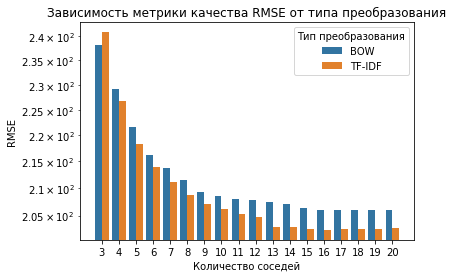

In [47]:
sns.barplot(x='Количество соседей',
            y='RMSE',
            hue='Тип преобразования',
            data=logs_data[best_selection])
plt.semilogy()
plt.title('Зависимость метрики качества RMSE от типа преобразования')
plt.show()

По графику можно заметить, что алгоритм с преобразованием текстовых признаков **TF-IDF** превосходит аналогичный алгоритм, но с преобразованием **Bag of words**. Это происходит из-за того, что **TF-IDF** дополнительно учитывает информацию об уникальности слов (В данном эксперименте на качество не влияет нормировка, которая входит в **TF-IDF**, так как используется косинусная метрика расстояния).

### Зависимость RMSE от метрики:
В данном эксперименте используется **Bag of words** в качетсве преобразования текстовых признаков.

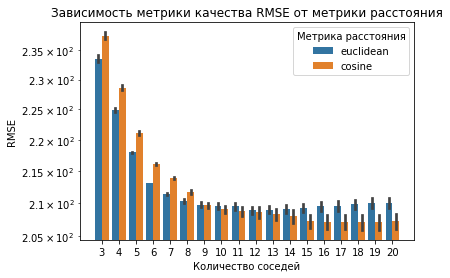

In [105]:
sns.barplot(x='Количество соседей',
            y='RMSE',
            hue='Метрика расстояния',
            data=logs_data[logs_data['Тип преобразования'] == 'BOW'])
plt.semilogy()
plt.title('Зависимость метрики качества RMSE от метрики расстояния')
plt.show()

Практически во всех случаях наилучшее качество дает косинусная метрика. Это объясняется тем, что при преобразовании **Bag of words** значения признаков не нормированы, а евклидова метрика чувствительна к масштабу.

### Зависимость RMSE от количества соседей:

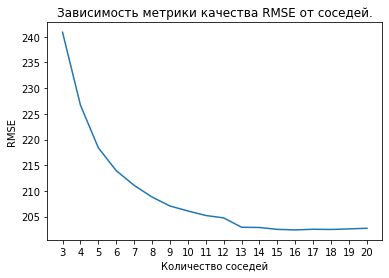

In [49]:
sns.lineplot(x='Количество соседей',
            y='RMSE',
            data=logs_data[best_selection & (logs_data['Тип преобразования'] == 'TF-IDF')])
plt.title('Зависимость метрики качества RMSE от соседей.')
plt.xticks(logs_data['Количество соседей'].unique())
plt.show()

По графику видно, что ошибка убывает с ростом количества соседей. Это логично, так как предсказания усредняются по бОльшему числу похожих объектов. Но такое поведение графика не будет сохраняться при достаточно больших значениях $k$. Например, при $k = l$, где $l$ - количество объектов в тренировочной выборке модель выраждается в константный предсказатель (если рассматривается модель без весов), где предсказание для объекта из теста равно среднему значению целевой переменной по всей тренировочной выборке.

<b>3.2 (1 балл)</b> Используя все доступные признаки, решите задачу регрессии. Для категориальных и текстовых признаков выберите лучшие преобразования. Повлияло ли добавление количественного признака на метрику качества?

### Будем проверять на евклидовой метрике, используя лучшие преобразования для категориальных и текстовых признаков:
    1) Добавим все признаки из 2.4 (без фолдинга)
    2) Добавим признаки, использующие функцию g = mean.
    3) Добавим все текстовые признаки, полученные с помощью TF-IDF
    4) Все исходные числовые признаки (кроме тех, что являются неинформативными)

In [83]:
cat_columns = ['neighbourhood_group', 'neighbourhood', 'room_type']
numeric_columns = ['latitude',
                   'longitude',
                   'room_type',
                   'minimum_nights',
                   'number_of_reviews',
                   'reviews_per_month',
                   'calculated_host_listings_count',
                   'availability_365'] 
text_columns = ['name', 'host_name']

data_numerical = data.copy()

### Закодируем категориальные призаки (из-за этого быстрее считаются статистики):

In [84]:
from sklearn.preprocessing import LabelEncoder

In [85]:
le = LabelEncoder()
for column in cat_columns:
    all_classes_in_col = data_numerical[column].unique()
    le.fit(all_classes_in_col)
    data_numerical.loc[:, column] = le.transform(data_numerical.loc[:, column]) + 1

### Разобьем данные на тренировочную и тестовую выборки.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(data_numerical.drop(columns=['price', 'target']),
                                                    data_numerical[['price', 'target']],
                                                    test_size=0.3, random_state=241)

### Сгенерируем признаки-счетчики:

In [87]:
counter_features_train = counters(X_train[cat_columns], X_train[cat_columns], y_train['target'])
counter_features_test = counters(X_test[cat_columns], X_train[cat_columns], y_train['target'])

### Сгенерируем признаки из пункта 2.5 с помощью функции $mean$

In [88]:
p_j_feature_train, p_j_feature_test = calculate_p_j_for_df(X_train[cat_columns],
                                                           X_test[cat_columns],
                                                           y_train['price'],
                                                           np.mean)

### Добавим полученные признаки в тренировочную и тестовую выборки

In [90]:
X_train = pd.concat([X_train, counter_features_train, p_j_feature_train], axis=1)
X_test = pd.concat([X_test, counter_features_test, p_j_feature_test], axis=1)

### Выкинем текстовые, категориальные и неинформативные признаки

In [91]:
X_train.drop(text_columns + cat_columns + ['id', 'host_id', 'last_review'], axis=1, inplace=True)
X_test.drop(text_columns + cat_columns + ['id', 'host_id', 'last_review'], axis=1, inplace=True)

In [92]:
y_train = y_train['price']
y_test = y_test['price']

In [93]:
X_train_arr = X_train.to_numpy()
X_train_with_text_arr = X_train_with_text.toarray()
X_test_arr = X_test.to_numpy()
X_test_with_text_arr = X_test_with_text.toarray()

### Объединим преобразованные текстовые признаки с помощью TF-IDF с признаками, полученными выше

In [94]:
X_train_full = np.hstack([X_train_with_text_arr, X_train_arr])
X_test_full = np.hstack([X_test_with_text_arr, X_test_arr])

### Проверим качество при различных параметрах алгоритма:

In [95]:
knn_final = KNNRegressor(10, metric='cosine', mode='distance', test_block_size=10000)
knn_final.fit(X_train_full, y_train)

In [96]:
%%time
preds = knn_final.predict(X_test_full)

CPU times: user 57min 1s, sys: 59.3 s, total: 58min
Wall time: 7min 37s


In [97]:
rmse_score = rmse(preds, y_test_with_text.reshape(-1))

In [98]:
rmse_score

211.96843602617872

In [99]:
knn_final = KNNRegressor(10, metric='euclidean', mode='distance', test_block_size=10000)
knn_final.fit(X_train_full, y_train)

In [100]:
%%time
preds = knn_final.predict(X_test_full)

CPU times: user 56min 29s, sys: 1.07 s, total: 56min 30s
Wall time: 7min 19s


In [101]:
rmse_score = rmse(preds, y_test_with_text.reshape(-1))
rmse_score

210.62106781496394

In [102]:
knn_final = KNNRegressor(10, metric='cosine', mode='uniform', test_block_size=10000)
knn_final.fit(X_train_full, y_train)

In [103]:
%%time
preds = knn_final.predict(X_test_full)

CPU times: user 57min 3s, sys: 20.1 s, total: 57min 23s
Wall time: 7min 32s


In [104]:
rmse_score = rmse(preds, y_test_with_text.reshape(-1))
rmse_score

211.75320399337258

### Попробуем пронормировать все признаки:

In [106]:
from sklearn.preprocessing import StandardScaler

In [111]:
scaler = StandardScaler(copy=True)
X_train_full = scaler.fit_transform(X_train_full)
X_test_full = scaler.transform(X_test_full)

In [112]:
knn_final = KNNRegressor(10, metric='euclidean', mode='uniform', test_block_size=10000)
knn_final.fit(X_train_full, y_train)

In [113]:
%%time
preds = knn_final.predict(X_test_full)

CPU times: user 57min 20s, sys: 834 ms, total: 57min 21s
Wall time: 7min 25s


In [114]:
rmse_score = rmse(preds, y_test_with_text.reshape(-1))
rmse_score

211.60747897419836

С помощью добавления дополнительных признаков и их нормировки не удалось превзойти качество, полученное только при преобразовании текстовых признаков.

## Часть 4: Выводы


(ノ°∀°)ノ⌒･*:.｡. .｡.:*･゜ﾟ･*☆ (ノ°∀°)ノ⌒･*:.｡. .｡.:*･゜ﾟ･*☆ (ノ°∀°)ノ⌒･*:.｡. .｡.:*･゜ﾟ･*☆ (ノ°∀°)ノ⌒･*:.｡. .｡.:*･゜ﾟ･*☆

В данной работе были проведены эксперименты с методом $k$ ближайших соседей для задачи регресии (и немного для задачи классификации). Были изучены и реализованы метрики расстояния между категориальными признаками; преобразования категориальных и текстовых признаков в вещественные для использования их со стандартными метриками расстояния: $cosine$, $euclidean$.